In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from matplotlib.colors import LogNorm
import csv

In [3]:
%load_ext autoreload
%autoreload 2
from get_prob_matrix import get_prob_matrix
from get_prob_matrix_symmetry import get_prob_matrix_symmetry
from get_fundamental_matrix import get_fundamental_matrix
from get_mean_time import get_mean_time
from get_games_strategy import get_games_strategy
from get_games_hist_2d import get_games_hist_2d
from make_prob_matrix import make_prob_matrix

In [4]:

def traverse_paths(x, y, val, N, strategy, strategies_answers, num_strategies):
    #print(x, y)
    if x < y:
        return
    if x == N - 1 and y == N - 1:
        #print('here', strategy)
        prv = strategy[x][y]
        strategy[x][y] = val
        strategies_answers.append(strategy.copy())
        strategy[x][y] = prv
        return
    if x >= N or y >= N:
        return
    if len(strategies_answers) > num_strategies:
        return 
    prv = strategy[x][y]
    strategy[x][y] = val
    if np.random.randint(2):
        traverse_paths(x + 1, y, val, N, strategy, strategies_answers, num_strategies)
        traverse_paths(x, y + 1, val, N, strategy, strategies_answers, num_strategies)
    else:
        traverse_paths(x, y + 1, val, N, strategy, strategies_answers, num_strategies)
        traverse_paths(x + 1, y, val, N, strategy, strategies_answers, num_strategies)

    strategy[x][y] = prv



In [12]:
N = 16
num_strategies = 10000000

strategies_answers = []
strategy = np.full((N + 1, N + 1), 0, dtype=np.float64)
traverse_paths(x=1, y=1, val=1, N=N, strategy=strategy, strategies_answers=strategies_answers, num_strategies=num_strategies)


In [9]:
len(strategies_answers)

14

In [8]:
2674440 * 20 / 60 / 24 / 44 / 2

422.10227272727275

In [39]:
2674440 / 5 / 2 / 2 / 2 / 3
2674440 / 60

44574.0

C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_14712/1150031700.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inside_mask = np.zeros_like(strategy_center, dtype=np.bool)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

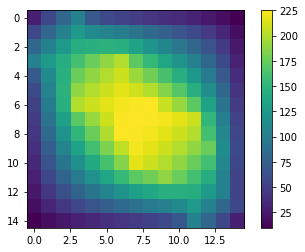

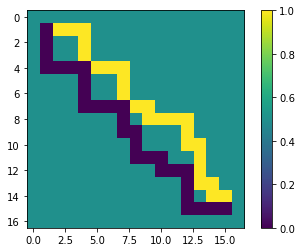

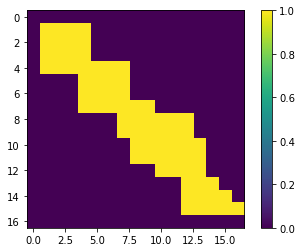

In [19]:
def make_banded_matrix(A, N):
    banded_matrix = np.zeros((2 * N + 1, N ** 2), dtype=np.float32)
    for i in [-N, -1, 0, 1, N]:
        d = np.diagonal(A, -i)
        if i < 0:
            banded_matrix[i + N, -i:] = d
        if i > 0:
            banded_matrix[i + N, :-i] = d
        if i == 0:
            banded_matrix[i + N, :] = d
    return banded_matrix

def find_mean_time_banded(A, N):
    banded_matrix = make_banded_matrix(np.eye(A.shape[0]) - A, N)
    import scipy
    mean_times = scipy.linalg.solve_banded((N, N), banded_matrix, np.ones(banded_matrix.shape[1]))
    return mean_times[N * (N // 2) + N // 2], mean_times

def find_mean_time(Q, N): # Sparse is slow
    mean_times = np.linalg.solve(np.eye(Q.shape[0]) - Q, np.ones(Q.shape[0]))
    return mean_times[N * (N // 2) + N // 2]


from tqdm import tqdm
N = 16
n = len(strategies_answers)
strategy_center = np.full((N + 1, N + 1), 0.5, dtype=np.float64)
strategy_border = np.full_like(strategy_center, 0.5)
cnt = 0
for i in [1]: # (range(n))
    for j in [100, 10000, 550000]: #tqdm(range(n))
        strategy_center[:, :] = 0.5
        strategy_center[strategies_answers[i].astype('bool').T] = 1
        strategy_center[strategies_answers[j].astype('bool')] = 0
        qr_optimal, probability_optimal = make_prob_matrix(N, strategy_center, strategy_border)
        
        mean_time, mean_times = find_mean_time_banded(probability_optimal, N - 1)
        condition = np.abs(mean_time - 225) > 1e-6

        plt.figure()
        plt.imshow(mean_times.reshape(N - 1, N - 1))
        plt.colorbar()
        
        plt.figure()
        plt.imshow(strategy_center)
        plt.colorbar()

        inside_mask = np.zeros_like(strategy_center, dtype=np.bool)
        for x in range(strategy_center.shape[0]):
            ok = False
            for y in range(strategy_center.shape[1]):
                if strategy_center[x][y] == 0:
                    ok = True
                if ok or strategy_center[x][y] != 0.5:
                    inside_mask[x][y] = 1
                if strategy_center[x][y] == 1:
                    ok = False

        plt.figure()
        plt.imshow(inside_mask)
        plt.colorbar()
        mean_times = mean_times.reshape(N - 1, N - 1)
        mean_times[inside_mask[1:-1, 1:-1]] = 0
        np.savetxt(f'../data/pairs/{i}_{j}.txt', mean_times, fmt='%8.2f')

        cnt += condition
        if condition:
            print(i, j, mean_time)


In [30]:
from numba import prange, jit, njit
@njit
def make_banded_matrix(A, N):
    banded_matrix = np.zeros((2 * N + 1, A.shape[0]), dtype=np.float32)
    for i in [-N, -1, 0, 1, N]:
        #d = np.diagonal(A, -i)
        for j in range(A.shape[0]):
            if j + i >= 0 and j + i < A.shape[0]:
                banded_matrix[i + N, j] = A[j + i, j]
        '''
        if i < 0:
            banded_matrix[i + N, -i:] = d
        if i > 0:
            banded_matrix[i + N, :-i] = d
        if i == 0:
            banded_matrix[i + N, :] = d
            '''
    return banded_matrix

import scipy
@njit
def find_mean_time_banded(A, N):
    banded_matrix = make_banded_matrix(np.eye(A.shape[0]) - A, N)
    mean_times = scipy.linalg.solve_banded((N, N), banded_matrix, np.ones(banded_matrix.shape[1]))
    return mean_times[N * (N // 2) + N // 2]

def find_mean_time(Q, N): # Sparse is slow
    mean_times = np.linalg.solve(np.eye(Q.shape[0]) - Q, np.ones(Q.shape[0]))
    return mean_times[N * (N // 2) + N // 2]

from tqdm import tqdm
from make_prob_matrix import make_prob_matrix
    
@jit(nopython=True, parallel=True)
def traverse_all_pairs(strategies_answers):
    N = 16
    n = len(strategies_answers)
    strategy_center = np.full((N + 1, N + 1), 0.5, dtype=np.float64)
    strategy_border = np.full_like(strategy_center, 0.5)
    cnt = 0
    #n = 10000
    for i in (range(n)):
        #res = np.zeros((n, (N - 1)**2, (N - 1)**2), dtype=np.float32)
        for j in prange(n):
            
            strategy_center[:, :] = 0.5
            for x in range(strategy_center.shape[0]):
                for y in range(strategy_center.shape[1]):
                    if strategies_answers[i, x, y]:
                        strategy_center[y, x] = 1
                    if strategies_answers[j, x, y]:
                        strategy_center[x, y] = 0
            qr_optimal, probability_optimal = make_prob_matrix(N, strategy_center, strategy_border)
            #res[j, :, :] = np.eye(probability_optimal.shape[0]) - probability_optimal
            #fundamental_matrix_border = get_fundamental_matrix(probability_optimal)
            #mean_time = get_mean_time(N - 1, fundamental_matrix_border)
            mean_time = find_mean_time_banded(probability_optimal, N - 1)
            '''
            condition = np.abs(mean_time - 225) > 1e-6
            cnt += condition
            if condition:
                print(i, j, mean_time)
            '''
        #cur = np.linalg.solve(res, np.ones((res.shape[0], res.shape[1])))
        #cur = np.linalg.inv(res)
        #print(cur.shape)
    return cnt

traverse_all_pairs(np.array(strategies_answers))


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'solve_banded' of type Module(<module 'scipy.linalg' from 'C:\\ProgramData\\Anaconda3\\envs\\py39\\lib\\site-packages\\scipy\\linalg\\__init__.py'>)
[1m
File "C:\Users\MIKE_L~1\AppData\Local\Temp\ipykernel_21920\1757895974.py", line 24:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_21920/1757895974.py (24)[0m
[1m
File "C:\Users\MIKE_L~1\AppData\Local\Temp\ipykernel_21920\1757895974.py", line 24:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function find_mean_time_banded at 0x0000015E3BECBC10>))[0m
[0m[1mDuring: typing of call at C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_21920/1757895974.py (57)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function find_mean_time_banded at 0x0000015E3BECBC10>))[0m
[0m[1mDuring: typing of call at C:\Users\MIKE_L~1\AppData\Local\Temp/ipykernel_21920/1757895974.py (57)
[0m
[1m
File "C:\Users\MIKE_L~1\AppData\Local\Temp\ipykernel_21920\1757895974.py", line 57:[0m
[1m<source missing, REPL/exec in use?>[0m


In [29]:
make_banded_matrix(np.arange(0, 100).reshape(10, 10), 3)

array([[ 0.,  0.,  0.,  3., 14., 25., 36., 47., 58., 69.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., 12., 23., 34., 45., 56., 67., 78., 89.],
       [ 0., 11., 22., 33., 44., 55., 66., 77., 88., 99.],
       [10., 21., 32., 43., 54., 65., 76., 87., 98.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [30., 41., 52., 63., 74., 85., 96.,  0.,  0.,  0.]], dtype=float32)

In [27]:
np.arange(0, 100).reshape(10, 10)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

225.00000000000017

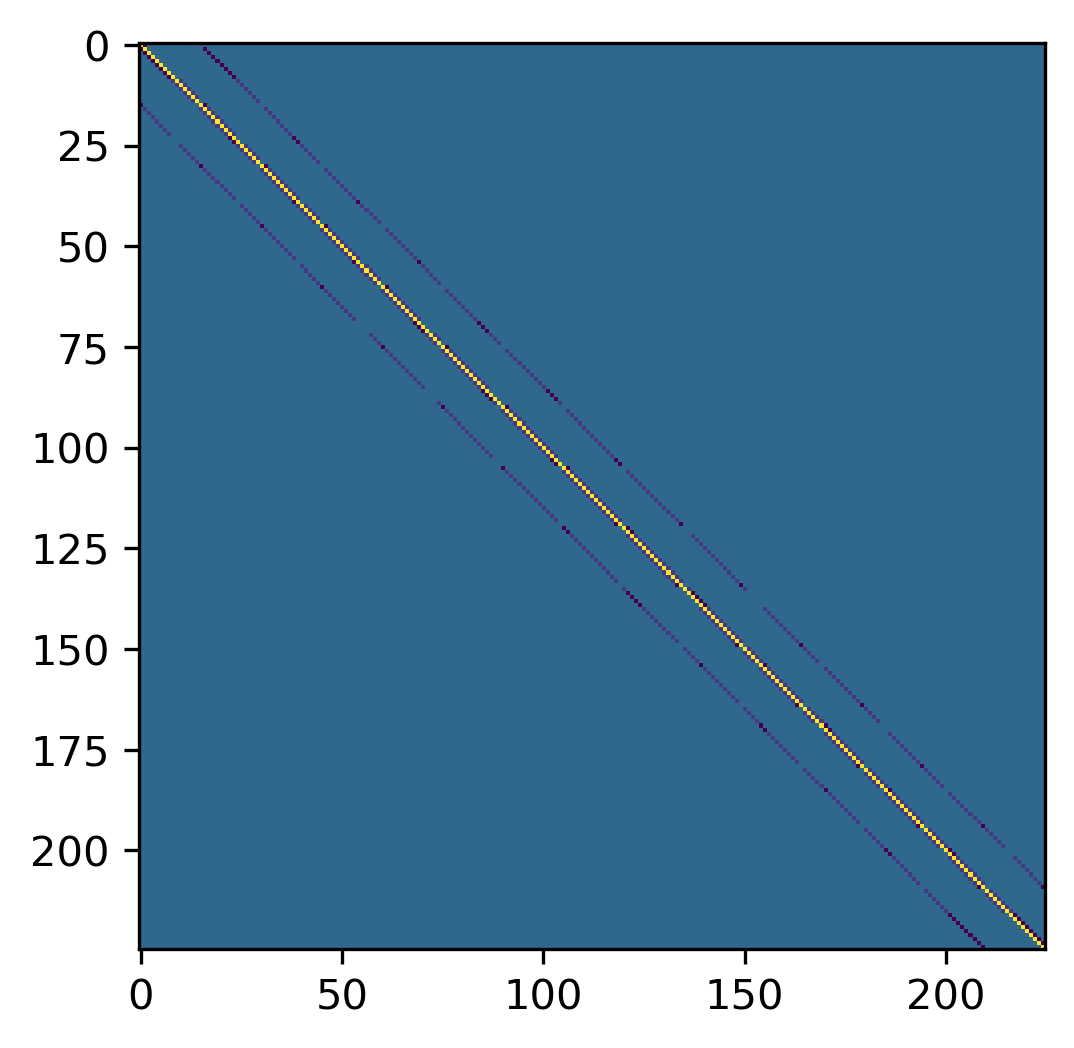

In [76]:
A = res[0, :, :].copy()
plt.figure(dpi=300)
plt.imshow(A)

find_mean_time_banded(A, N - 1)

In [58]:
np.diagonal(A, 1).shape

(224,)

224.99999999999986


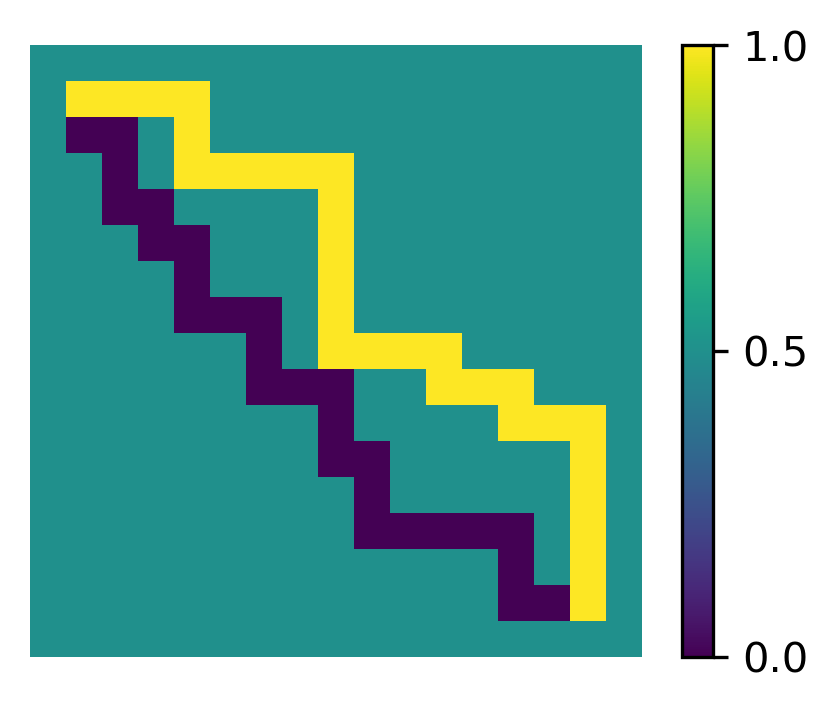

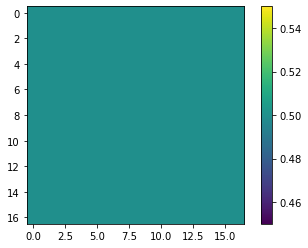

In [137]:
N = 16
'''num_strategies = 1000

strategies_answers = []
strategy = np.full((N + 1, N + 1), 0, dtype=np.float64)
traverse_paths(x=1, y=1, val=1, N=N, strategy=strategy, strategies_answers=strategies_answers, num_strategies=num_strategies)
'''

id_1 = np.random.randint(len(strategies_answers))
id_2 = np.random.randint(len(strategies_answers))
strategy_center = np.full((N + 1, N + 1), 0.5, dtype=np.float64)
strategy_center[strategies_answers[id_1].astype('bool')] = 0
strategy_center[strategies_answers[id_2].astype('bool').T] = 1

strategy_border = np.full_like(strategy_center, 0.5)
#strategy_center[1, 1] = 0.5
#strategy_center[N - 1, N - 1] = 0.5

'''
strategy_center = np.full((N + 1, N + 1), 0.5, dtype=np.float64)
for i in range(1, N):
    strategy_center[i, 1] = 0
    strategy_center[1, i] = 1
    strategy_center[N - 1, i] = 0
    strategy_center[i, N - 1] = 1

'''
plt.figure(figsize=(3.5, 2.7), dpi=300)
plt.imshow(strategy_center)
cbar = plt.colorbar()
plt.axis(False)
plt.subplots_adjust()
cbar.set_ticks([0, 0.5, 1])
image_dir = '../../PvE_optimal/'
import glob
files = glob.glob(image_dir + 'strategy_random_optimal*.png')
image_id = len(files)
plt.savefig(image_dir + f'strategy_random_optimal_{image_id}.png')

plt.figure()
plt.imshow(strategy_border)
plt.colorbar()


qr_optimal, probability_optimal  = make_prob_matrix(N, strategy_center, strategy_border)

fundamental_matrix_border = get_fundamental_matrix(probability_optimal)
mean_time = get_mean_time(N - 1, fundamental_matrix_border)
print(mean_time)

In [91]:
print()

224.99999999999977


In [69]:
np.sum(probability_matrix_optimal, 0), probability_matrix_optimal.shape

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 1.  , 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.  ,
        0.  , 0.  , 1.25, 1.5 , 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25,
        1.25, 1.25, 1.25, 1.25, 1.5 , 0.75, 0.  , 0.  , 0.75, 1.25, 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.25,
        0.75, 0.  , 0.  , 0.75, 1.25, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.25, 0.75, 0.  , 0.  , 0.75, 1.25,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.25, 0.75, 0.  , 0.  , 0.75, 1.25, 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.25, 0.75, 0.  , 0.  , 0.75,
        1.25, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.25, 0.75, 0.  , 0.  , 0.75, 1.25, 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 